In [1]:
import time
import os
import os.path as osp
import sys
import io
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

from astroML.datasets import sdss_corrected_spectra

from models import *
from solve_inverse import *
from statistics import mean
from math import sqrt
from bisect import bisect

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device Used: " + str(device))

print(torch.get_num_threads())

# set random seed
manual_seed = 13
random.seed(manual_seed)
torch.manual_seed(manual_seed)

Device Used: cpu
4


Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=101, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(101, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=101, out_features=153, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(153, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Linear(in_features=153, out_features=204, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(204, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Linear(in_features=204, out_features=

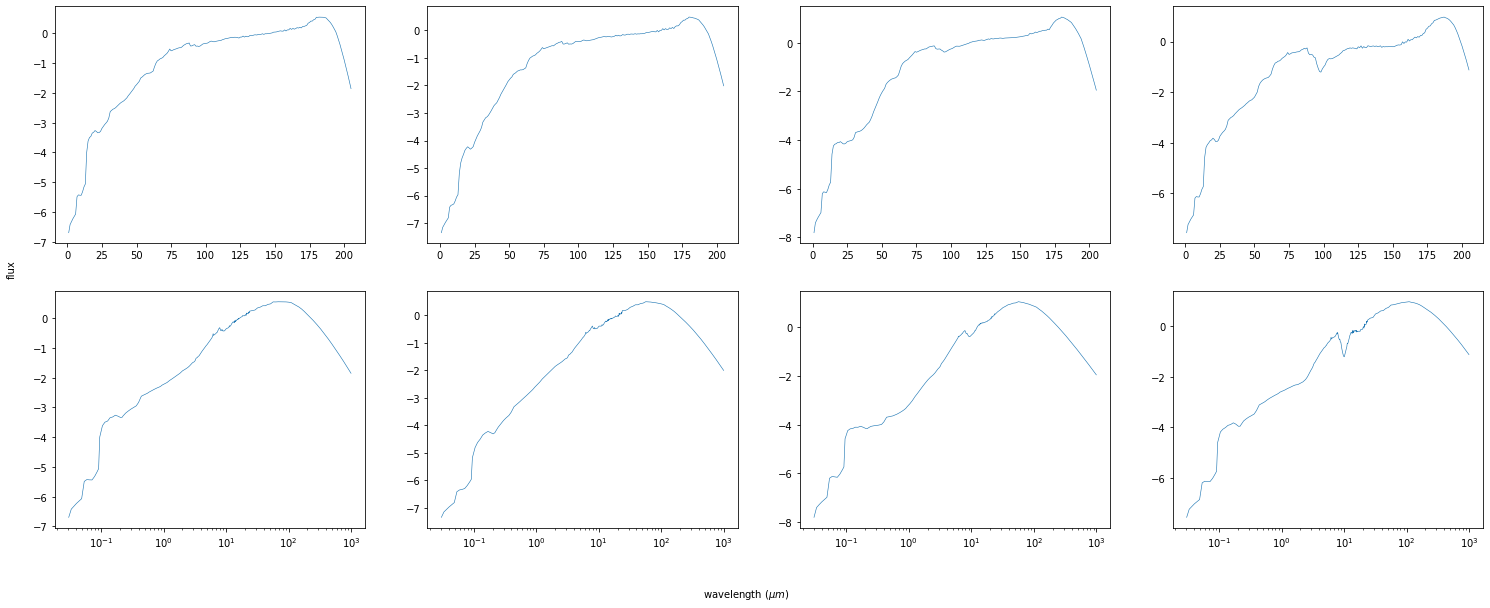

In [25]:
### Config

## Data 

dataset_dir = "./Data/Dataset_5_35"

data = "log"  #""

training_5_35 = np.load(osp.join(dataset_dir,"spectra_complete_training_5_35.npy"))
test_5_35 = np.load(osp.join(dataset_dir,"spectra_complete_testing_5_35.npy"))

training_complete = np.load(osp.join(dataset_dir,"spectra_complete_training.npy"))
test_complete = np.load(osp.join(dataset_dir,"spectra_complete_testing.npy"))

training_log = np.load(osp.join(dataset_dir,"log_training.npy"))
test_log = np.load(osp.join(dataset_dir,"log_test.npy"))

training_reduced = np.load(osp.join(dataset_dir,"spectra_reduced_training.npy"))
test_reduced = np.load(osp.join(dataset_dir,"spectra_reduced_testing.npy"))

training_ids = np.load(osp.join(dataset_dir,"training_ids.npy"))
test_ids = np.load(osp.join(dataset_dir,"test_ids.npy"))

wavelengths_complete_5_35 = np.load(osp.join(dataset_dir,"wavelenths_complete_5_35.npy"))
wavelengths_complete = np.load(osp.join(dataset_dir,"wavelenths_complete.npy"))
wavelengths_reduced = np.load(osp.join(dataset_dir,"wavelenths_reduced.npy"))


#manually delete very high wavelengths
NLA_max = 205
if data=="log":
    training = training_log[:,:NLA_max]
    test = test_log[:,:NLA_max]
else:
    training = training_complete[:,:NLA_max]
    test = test_complete[:,:NLA_max]
wavelengths = wavelengths_complete[:NLA_max]


TRAINING_DATA = training.shape[0]
TEST_DATA = test.shape[0]
FEATURE_SIZE = training.shape[1]
REDUCED_DATA = test_reduced.shape[0]
REDUCED_FEATURES = test_reduced.shape[1]
NLA = wavelengths.shape[0]
NLA_reduced = wavelengths_reduced.shape[0]



## Model

model = "glo" #"glo" "wgan"

result_dir = './trained_models/'
if model=="glo":
    result_folder = result_dir + data + model.upper() 
    iter_saved = 10000
    latent = torch.load(osp.join(result_folder,"learned_latent_codes.pth"))
if model=="wgan": 
    result_folder = result_dir + data + model.upper() + '-2' # change the models
    iter_saved = 15000 #10000-log

# GLO training requires restriction of latent code in the l2 unit ball 
def project_l2_ball(z):
    """ project the vectors in z onto the l2 unit norm ball"""
    z_l2_norm = torch.norm(z, p=2, dim=0).detach()
    if z_l2_norm.item() > 1:
        z = z.div(z_l2_norm.expand_as(z))
    return z

LATENT_SIZE = 50
d = 6
netG = Generator(nz=LATENT_SIZE, nf=FEATURE_SIZE, num_hidden_layers=d)
netG.load_state_dict(torch.load(osp.join(result_folder,"learned_generator_" + str(iter_saved) + ".pth")))
netG.eval()

print(netG)


## Evaluation on random samples

# Plot a random sample (4) generated by netG
latent_rand = torch.randn(4, LATENT_SIZE, device=device)
if model=="glo":
    for i in range(4):
        latent_rand[i] = project_l2_ball(latent_rand[i])
    
#change font size
plt.rcParams.update({'font.size':10})
fig = plt.figure(figsize=[4*6.4, 2*4.8])
ax1_u = fig.add_subplot(241)
ax2_u = fig.add_subplot(242)
ax3_u = fig.add_subplot(243)
ax4_u = fig.add_subplot(244)
axis_u = [ax1_u,ax2_u,ax3_u,ax4_u]

ax1_d = fig.add_subplot(245)
ax2_d = fig.add_subplot(246)
ax3_d = fig.add_subplot(247)
ax4_d = fig.add_subplot(248)
axis_d = [ax1_d,ax2_d,ax3_d,ax4_d]

# Argument explanation: grid with 2 x 4 images (2 rows, 4 columns), 
#                       last argument is counting from left to right and top to bottom

for i in range(4):
    sample = netG(latent_rand[i].unsqueeze(0)).squeeze(0).detach().numpy()
    axis_u[i].plot(range(1,FEATURE_SIZE+1), sample, linewidth=0.6)
    axis_d[i].set_xscale('log')
    if data!="log":
        axis_d[i].set_yscale('log')
    axis_d[i].plot(wavelengths, sample, linewidth=0.6)
    
# Set common labels
fig.text(0.5, 0.03, 'wavelength $(\u03bcm)$', ha='center', va='center')
fig.text(0.102, 0.5, 'flux', ha='center', va='center', rotation='vertical')


# Test ids for qualitative results:
ids_1 = [265,297,701,931]
ids_2 = [700, 821, 869, 911]
ids_3 = [266,298,702,932]
ids_4 = [701, 822, 870, 912]
test_ids_hardcoded_list = [266,298,702,932,701, 822, 870, 912,265,297,701,931,700, 821, 869, 911]
print("Test sample original ids: ",test_ids[test_ids_hardcoded_list])

# SUPER-RESOLUTION real application

### QUALITATIVE EVALUATION

Measured wavelength values:
[5.1000e-02 7.6333e-02 1.1833e-01 2.1667e-01 2.6367e-01 3.0267e-01
 3.2600e-01 4.1367e-01 5.3667e-01 7.2333e-01 1.1853e+00 1.5003e+00
 1.9150e+00 2.6393e+00 7.8647e+00 3.3550e+01 5.3659e+01 8.2847e+01
 1.1605e+02 1.6693e+02]
./trained_models/logGLO/logGLO_qualitative_real


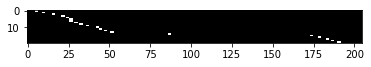

In [3]:
## Problem Setup

inverse_problem = "superresolution_real"

print("Measured wavelength values:")
print(wavelengths_reduced)

res_dir = osp.join(result_folder, data + model.upper() + "_qualitative_real")
if not osp.exists(res_dir):
    os.mkdir(res_dir)
    
## used to restrict the reconstruction into the 5-35 range ([:, idx_low:(idx_high+1)])
low_wv = 5
high_wv = 35
idx_low = bisect(wavelengths, low_wv)
idx_high = bisect(wavelengths, high_wv)

idx_reduced_low = bisect(wavelengths_reduced, low_wv)
idx_reduced_high = bisect(wavelengths_reduced, high_wv)

## Construct The A matrix for the real superresolution application
A_superres_real = torch.zeros((NLA_reduced, NLA), device=device)

for i,wv in enumerate(wavelengths_reduced):
    idx = bisect(wavelengths, wv)
    if idx>0 and idx<NLA:
        A_superres_real[i][idx-1] = 0.5
        A_superres_real[i][idx] = 0.5

plt.imshow(A_superres_real, interpolation='nearest', cmap=cm.Greys_r)

print(res_dir)

Reconstruction of id 701
Epoch [100/1000], Loss: 0.5008
Epoch [200/1000], Loss: 0.1209
Epoch [300/1000], Loss: 0.0391
Epoch [400/1000], Loss: 0.0169
Epoch [500/1000], Loss: 0.0088
Epoch [600/1000], Loss: 0.0051
Epoch [700/1000], Loss: 0.0033
Epoch [800/1000], Loss: 0.0024
Epoch [900/1000], Loss: 0.0018
Epoch [1000/1000], Loss: 0.0014
Reconstruction of id 822
Epoch [100/1000], Loss: 0.2002
Epoch [200/1000], Loss: 0.0224
Epoch [300/1000], Loss: 0.0024
Epoch [400/1000], Loss: 0.0011
Epoch [500/1000], Loss: 0.0010
Epoch [600/1000], Loss: 0.0009
Epoch [700/1000], Loss: 0.0009
Epoch [800/1000], Loss: 0.0009
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008
Reconstruction of id 870
Epoch [100/1000], Loss: 0.1475
Epoch [200/1000], Loss: 0.0773
Epoch [300/1000], Loss: 0.0066
Epoch [400/1000], Loss: 0.0038
Epoch [500/1000], Loss: 0.0030
Epoch [600/1000], Loss: 0.0028
Epoch [700/1000], Loss: 0.0027
Epoch [800/1000], Loss: 0.0026
Epoch [900/1000], Loss: 0.0025
Epoch [1000/1000], Loss:

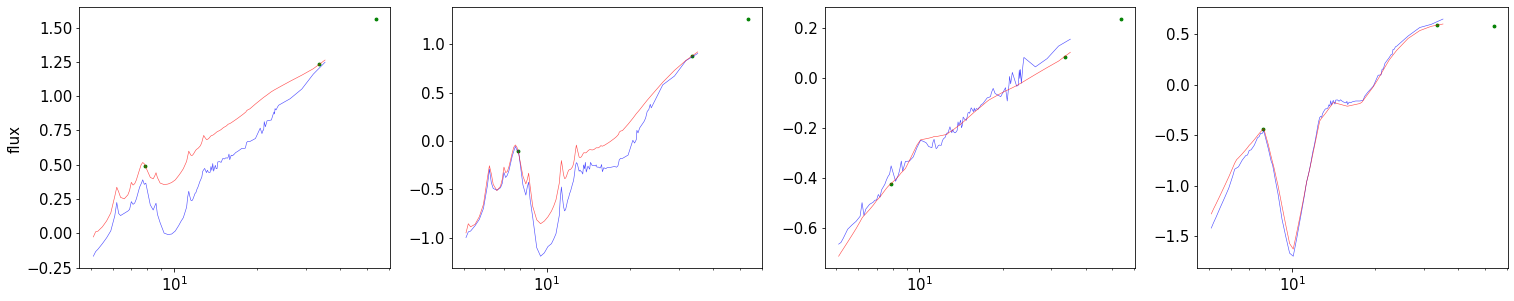

In [4]:
## Solve the inverse problem for a small sample (qualitative evaluation)

ids = random.sample(range(0,REDUCED_DATA), 4)
ids_1 = [265,297,701,931]
ids_2 = [700, 821, 869, 911]
ids_3 = [266,298,702,932]
ids_4 = [701, 822, 870, 912]
ids = ids_4

complete = False
zoom = True

# save runs
verbose = True
rerun = True
if rerun and not osp.exists(osp.join(res_dir, "saved_runs")):
    os.mkdir(osp.join(res_dir, "saved_runs"))
    

plt.rcParams.update({'font.size':15})
fig = plt.figure(figsize=[4*6.4, 4.8])
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
axis = [ax1,ax2,ax3,ax4]

REG_LAMBDA = 0.0   #0.0  1e-5
LR = 0.001

for cnt,i in enumerate(ids):
    if rerun:
        print("Reconstruction of id " + str(i))
        # measurements
        y = torch.tensor(test_reduced[i], device=device)
        if data=="log":
            y = torch.log10(y)
        # real super-res application
        A = A_superres_real
        # solve inverse
        z = solve_inverse(netG, y, A, LATENT_SIZE, device, max_epochs=1000, lr=LR, 
                          optm="adam", regularization_lambda=REG_LAMBDA, verbose=verbose)
        inv = netG(z.unsqueeze(0)).squeeze(0).detach()
        #get original signal 
        original = test[i]
        #save run
        y = y.numpy()
        # pad measurements to match high-dim data
        y_padded = np.pad(y,(0, NLA - NLA_reduced), 'constant')
        inv = inv.numpy()
        to_save = np.vstack((y_padded, inv, original))
        np.save(osp.join(res_dir, "saved_runs", inverse_problem+"__y_padded-inv_fig" + str(cnt) +".npy"), to_save)
    else:
        data = np.load(osp.join(res_dir, "saved_runs", inverse_problem+"__y_padded-inv_fig" + str(cnt) +".npy"))
        y = data[0]
        # un-pad measurements
        y = y[:NLA_reduced]
        inv = data[1]
        original = data[2]
    #restrict the reconstruction into the 5 - 35 range
    inv_5_35 = inv[idx_low:(idx_high+1)]
    #create fig
    axis[cnt].set_xscale('log')
    if data!="log":
        axis[cnt].set_yscale('log')
    axis[cnt].plot(wavelengths_complete_5_35, inv_5_35, alpha=0.7, linewidth=0.6, color = 'blue')
    if complete:
        axis[cnt].scatter(wavelengths_reduced, y, s=8, color = 'green')
        axis[cnt].plot(wavelengths, original, alpha=0.7, linewidth=0.6, color = 'red')
    elif zoom:
        y__5_35 = y[idx_reduced_low:(idx_reduced_high+1)]
        wavelengths_reduced_5_35 = wavelengths_reduced[idx_reduced_low:(idx_reduced_high+1)]
        axis[cnt].scatter(wavelengths_reduced_5_35, y__5_35, s=8, color = 'green')
        axis[cnt].plot(wavelengths_complete_5_35, original[idx_low:(idx_high+1)], alpha=0.7, linewidth=0.6, color = 'red')
    else:
        print("sorry wrong number")
    
    
# Set common labels
#fig.text(0.5, 0.01, 'wavelength $(\u03bcm)$', ha='center', va='center')
fig.text(0.09, 0.5, 'flux', ha='center', va='center', rotation='vertical')
fig.savefig(osp.join(res_dir,inverse_problem + "-zoom-4.pdf"), bbox_inches='tight')

### QUANTITATIVE EVALUATION

In [27]:
## Recover test ids from log

#TODO: save those with the runs

test_ids = np.load(osp.join(result_dir, "test_ids.npy"))
print(test_ids)

[654 114  25 759 281 250 228 142 754 104 692 758 913 558  89 604 432  32
  30  95 223 238 517 616  27 574 203 733 665 718 986 429 225 459 603 284
 828 890   6 777 825 163 714 983 348 964 159 220 781 344 990  94 389  99
 367 867 352 618 270 826  44 747 470 549 127 387  80 565 300 849 643 633
 906 882 370 591 196 721  71  46 677 233 791 296  81 875 978 887 103 947
 954 464 650 854 373 166 379 363 214 686]


logGLO_lambda_0.0_lr_0.001
Avg MSE: 0.19
Chi^2: 72


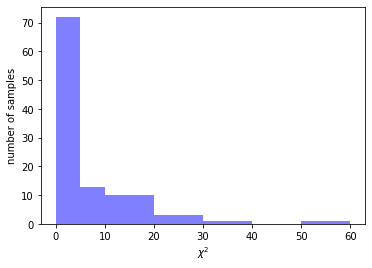

In [28]:
## Chi^2 measure
def chi_2_measure(x, y, ax=1):
    N = x.shape[ax]
    sigma_x = 0.1*x
    sigma_y = 0.1*y
    num = np.square(x - y)
    denom = np.square(sigma_x) + np.square(sigma_y)
    return (1/N)*np.divide(num, denom).sum(axis=ax)

## Mean Squared Error measure
def mse(x, y, ax=1):
    return np.square(x - y).mean(axis=ax)

LOG_EVAL = False

data = "log"  #""  "log"
model = "glo" #"glo" "wgan"
MODEL = data + model.upper() 
REG_LAMBDA = 0.0 #0.0  1e-5
LR = 0.001

res_dir = osp.join(result_folder, MODEL + "_quantitative_real")

run_config = "_lambda_" + str(REG_LAMBDA) + "_lr_" + str(LR)
saved_runs = np.load(osp.join(res_dir, "sample_runs" + run_config + ".npy"))
reconstructions = saved_runs[:,NLA_max:]
#originals = saved_runs[:,:NLA_max]
#print(np.sort(reconstructions.flatten()))

## evaluation in terms of logarithmic values
if LOG_EVAL:
    if data!="log":
        reconstructions = np.log10(reconstructions)
    target = np.log10(test_5_35[test_ids])
## evaluation in terms of original values
else:
    if data=="log":
        reconstructions = np.power(10, reconstructions)
    target = test_5_35[test_ids]

## used to restrict the reconstruction into the 5-35 range ([:, idx_low:(idx_high+1)])
low_wv = 5
high_wv = 35
idx_low = bisect(wavelengths, low_wv)
idx_high = bisect(wavelengths, high_wv)
reconstructions_5_35 = reconstructions[:, idx_low:(idx_high+1)]

## error measures' calculations
mse_5_35 = mse(reconstructions_5_35, target)
avg_mse_5_35 = np.mean(mse_5_35)
chi2s_5_35 = chi_2_measure(reconstructions_5_35, target)
chi2_5_35 = (chi2s_5_35 < 5).sum()

## print out aggregated errors
print(MODEL + run_config)
print("Avg MSE:",round(avg_mse_5_35,2))
print("Chi^2:",chi2_5_35)

## chi^2 histogram
plt.rcParams.update({'font.size':10})

bins = [0, 5, 10, 20, 30, 40, 50, 60]
plt.hist(chi2s_5_35, bins = bins, facecolor='blue', alpha=0.5)
plt.xlabel('$\chi^2 $')
plt.ylabel('number of samples')

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.savefig(osp.join(res_dir, "chi2_hist_"+run_config+".pdf"), bbox_inches='tight')